# LLM POS Tagger

This notebook will include the error analysis for the LLM POS Tagger.

As a prerequisite, you are required to run `uv run ud_pos_tagger_gemini.py`

In [1]:
# load hard sentences dataset and gemini classifications
import json

with open('hard_sentences.json', 'r') as f:
    hard_sentences = [s for s in json.load(f) if 1 <= s['errors'] <= 3]
with open('hard_sentences_gemini.json', 'r') as f:
    gemini_classifications = json.load(f)

## Error Analysis

### Frequenrly Misclassified Tokens (more than 10 misclassifications)

In [2]:
# Look only at tagging mistakes, not tokenization mistakes
llm_token_mistakes = [
    (tag['predicted_token'], row['sentence'], tag['predicted_tag'], tag['correct_tag'], i) 
    for row in gemini_classifications
    for i, tag in enumerate(row['tags'])
    if (
        'correct_token' not in tag 
        and 'correct_tag' in tag
    )
]

print("Analyzing frequent misclassifications...\n")

# Group by predicted token, sort by number of mistakes, and filter for those with 10 or more mistakes
token_to_llm_mistakes = {}
for token, sentence, predicted_tag, correct_tag, position in llm_token_mistakes:
    if token not in token_to_llm_mistakes:
        token_to_llm_mistakes[token] = []
    token_to_llm_mistakes[token].append((sentence, predicted_tag, correct_tag))
token_to_llm_mistakes = sorted(token_to_llm_mistakes.items(), key=lambda x: len(x[1]), reverse=True)
token_to_llm_mistakes_filtered = [(token, mistakes) for token, mistakes in token_to_llm_mistakes if len(mistakes) >= 10]

print(f"Found {len(token_to_llm_mistakes_filtered)} tokens misclassified more than 10 times\n")

# Print sentences for frequent mistakes
for token, mistakes in token_to_llm_mistakes_filtered:
    print(f"Token '{token}' - misclassified {len(mistakes)} times:")
    print(f"Example sentences:")
    for i, (sentence, predicted_tag, correct_tag) in enumerate(mistakes[:10]):
        print(f"  {i+1}. {sentence}")
        print(f"     Correct tag: {correct_tag}, Predicted tag: {predicted_tag}")
    print('-'*80)

Analyzing frequent misclassifications...

Found 17 tokens misclassified more than 10 times

Token 'that' - misclassified 52 times:
Example sentences:
  1. (And, by the way, is anybody else just a little nostalgic for the days when that was a good thing?)
     Correct tag: PRON, Predicted tag: DET
  2. The Supreme Court announced its ruling today in Hamdan v. Rumsfeld divided along idelogical lines with John Roberts abstaining due to his involvement at the D.C. Circuit level and Anthony Kennedy joining the liberals in a 5-3 decision that is 185 pages long.
     Correct tag: PRON, Predicted tag: SCONJ
  3. And international donors have given only half of the relief aid that Darfur needs, according to the local UN officials.
     Correct tag: PRON, Predicted tag: SCONJ
  4. em ... no ... the Gates foundation mainly invests in medical research and education, that means donating now adds a tremendous value compared to donating in ten years.
     Correct tag: PRON, Predicted tag: SCONJ
  5. 

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, idx_tag, title='Confusion Matrix', color_map='Blues', symetric=False, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    
    v = np.max(np.abs(cm))
    if symetric:
        cax = ax.matshow(cm, cmap=color_map, vmin=-v, vmax=v)
    else:
        cax = ax.matshow(cm, cmap=color_map)
    plt.colorbar(cax)

    # Add text annotations
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, f'{val}', va='center', ha='center')

    # Axis labels
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    labels = [idx_tag[i].value if idx_tag[i] else 'ERR' for i in range(len(idx_tag))]
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticklabels(labels)

    if not ax:
        plt.show()

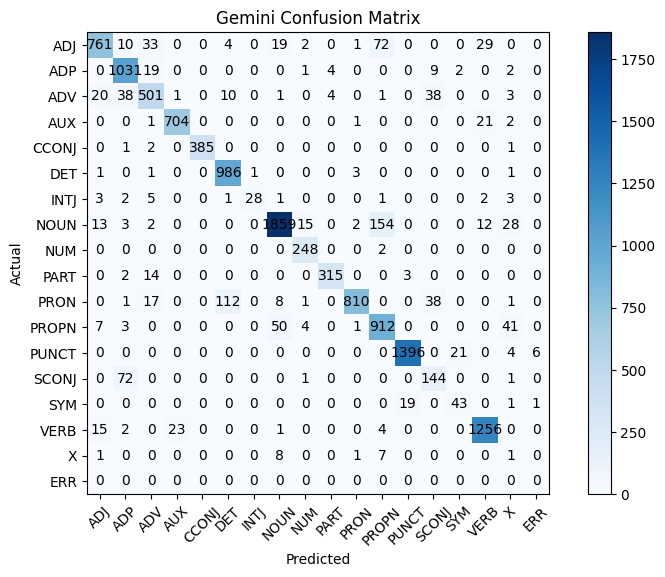

In [4]:
# Confusion matrix for Gemini
from schema import UDPosTag
import numpy as np


tag_idx = {tag: i for i, tag in enumerate(UDPosTag)} | {None: len(UDPosTag)}
idx_tag = {i: tag for tag, i in tag_idx.items()}
gemini_cm = np.zeros((len(UDPosTag) + 1, len(UDPosTag) + 1), dtype=int)

llm_token_preds = [
    (tag['predicted_token'], row['sentence'], tag['predicted_tag'], tag.get('correct_tag', tag['predicted_tag']))
    for row in gemini_classifications
    for i, tag in enumerate(row['tags'])
]

for token, sentence, predicted_tag, correct_tag in llm_token_preds:
    gemini_cm[tag_idx[correct_tag], tag_idx[predicted_tag]] += 1

plot_confusion_matrix(gemini_cm, idx_tag, title='Gemini Confusion Matrix')

#### Hard Cases for Gemini

1. Deictic words that can be pronoun or determiner - “this / that / these / those” act as PRON when they stand alone, but DET when they introduce a noun; Gemini tends to default to DET.
2. Discourse pronoun “there” vs. locative adverb - Expletive “there” (dummy subject) is PRON; locative “there” is ADV. The model over‑predicts ADV.
3. Subordinating conjunction vs. adposition - Words like for, in, to, so can head clauses (SCONJ) or prepositional phrases (ADP). Gemini prefers ADP.
4. Verb‑particle / adverb vs. preposition - Particles up, out, in, off, on after verbs are ADV (or PART), not ADP. Gemini often chooses the prepositional tag.
5. Possessive pronouns misread as determiners - Universal Dependencies treats my, your, his… as PRON (not DET). Gemini tags them as DET.

#### Sentences That Make Gemini Fail

Based on the identified hard cases, and the hard words - I selected the sentences below:

1. I’m not sure that was necessary.
2. The plan is for them to report back tomorrow.
3. Let’s wrap up before the boss shows up.
4. There were only fifteen in stock when I checked.
5. I grabbed the 2019‑2020 figures from the USD/JPY sheet.

### Comparison to Logistic Regression Tagger (LRT)

In [5]:
assert len(hard_sentences) == len(gemini_classifications), f"Mismatch between hard sentences {len(hard_sentences)} and gemini classifications {len(gemini_classifications)}"


results = {
    'gemini_correct_lrt_wrong': 0,
    'gemini_wrong_lrt_correct': 0,
    'gemini_correct_lrt_correct': 0,
    'gemini_wrong_lrt_wrong': 0,

    'gemini_token_mistakes': 0,
}


for lrt, gemini in zip(hard_sentences, gemini_classifications):
    assert lrt['original'] == gemini['sentence'], "The sentences in LRT and Gemini should be in the same order"
    assert len(lrt['tags']) == len(lrt['pred']), "LRT tags and predictions should have the same length"
    assert len(lrt['tags']) == len(gemini['tags']), "LRT tags and Gemini tags should have the same length"

    # penalize gemini for incorrect tokenization
    gemini_tokens_preds = [
        (tag['predicted_token'], tag['predicted_tag']) 
        if tag['predicted_token'] == correct_token
        else (correct_token, None)
        for tag, (correct_token, correct_tag) in zip(gemini['tags'], lrt['tags'])
    ]
    lrt_tokens_preds = [(tag[0], pred) for tag, pred in zip(lrt['tags'], lrt['pred'])]

    for (gemini_token, gemini_pred), (lrt_token, lrt_pred), (_, correct_pred) in zip(gemini_tokens_preds, lrt_tokens_preds, lrt['tags']):
        assert gemini_token == lrt_token, f"Tokenization mismatch: gemini token '{gemini_token}' != '{lrt_token}' lrt token"

        if gemini_pred is None:
            results['gemini_token_mistakes'] += 1
        elif gemini_pred == correct_pred and lrt_pred == correct_pred:
            results['gemini_correct_lrt_correct'] += 1
        elif gemini_pred == correct_pred and lrt_pred != correct_pred:
            results['gemini_correct_lrt_wrong'] += 1
        elif gemini_pred != correct_pred and lrt_pred == correct_pred:
            results['gemini_wrong_lrt_correct'] += 1
        elif gemini_pred != correct_pred and lrt_pred != correct_pred:
            results['gemini_wrong_lrt_wrong'] += 1

print("Results:")
total = sum(results.values())
print(f"Gemini correct, LRT wrong: {results['gemini_correct_lrt_wrong']} ({results['gemini_correct_lrt_wrong']/total:.2%})")
print(f"Gemini wrong, LRT correct: {results['gemini_wrong_lrt_correct']} ({results['gemini_wrong_lrt_correct']/total:.2%})")
print(f"Gemini correct, LRT correct: {results['gemini_correct_lrt_correct']} ({results['gemini_correct_lrt_correct']/total:.2%})")
print(f"Gemini wrong, LRT wrong: {results['gemini_wrong_lrt_wrong']} ({results['gemini_wrong_lrt_wrong']/total:.2%})")
print(f"Gemini token mistakes: {results['gemini_token_mistakes']} ({results['gemini_token_mistakes']/total:.2%})")

Results:
Gemini correct, LRT wrong: 645 (5.17%)
Gemini wrong, LRT correct: 625 (5.01%)
Gemini correct, LRT correct: 10722 (85.92%)
Gemini wrong, LRT wrong: 466 (3.73%)
Gemini token mistakes: 21 (0.17%)


#### Conclusion

Gemini is slightly better than LRT for this set of hard sentences

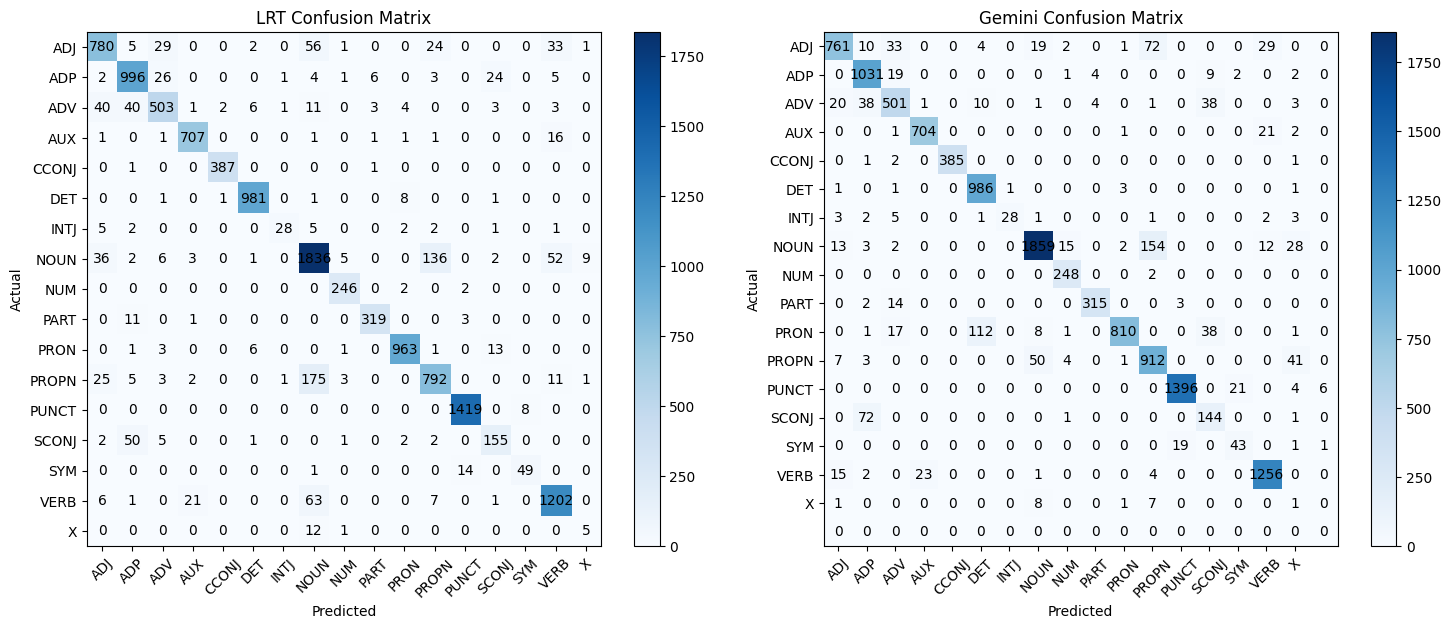

In [6]:
# Analyze the differences in a joint confusion matrix
tag_idx = {tag: i for i, tag in enumerate(UDPosTag)}
idx_tag = {i: tag for tag, i in tag_idx.items()}
lrt_cm = np.zeros((len(UDPosTag), len(UDPosTag)), dtype=int)

lrt_token_preds = [
    (token, row['original'], predicted_tag, correct_tag)
    for row in hard_sentences
    for (token, correct_tag), predicted_tag in zip(row['tags'], row['pred'])
]

for token, sentence, predicted_tag, correct_tag in lrt_token_preds:
    lrt_cm[tag_idx[correct_tag], tag_idx[predicted_tag]] += 1

# plot lrt_cm and gemini_cm side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_confusion_matrix(lrt_cm, idx_tag, title='LRT Confusion Matrix', ax=ax1)
plot_confusion_matrix(gemini_cm, idx_tag, title='Gemini Confusion Matrix', ax=ax2)
plt.tight_layout()
plt.show()

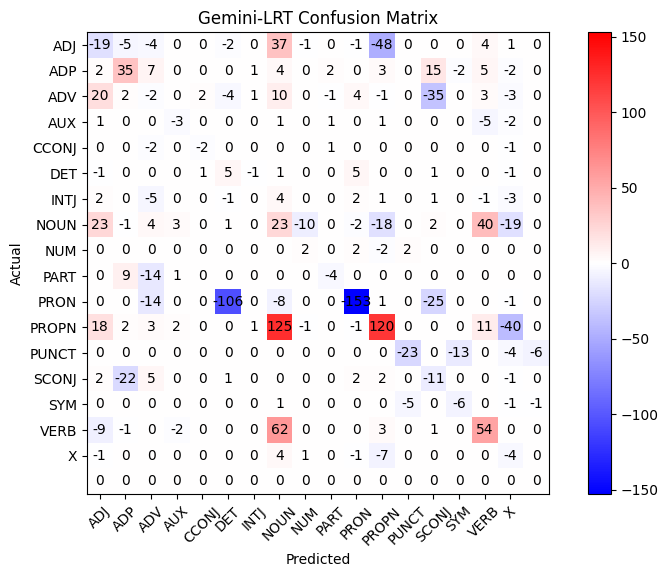

In [7]:

lrt_cm = np.pad(lrt_cm, ((0,1), (0,1)), mode='constant', constant_values=0)

diff_cm = np.empty_like(gemini_cm)
for i in range(len(UDPosTag) + 1):
    for j in range(len(UDPosTag) + 1):
        if i == j:
            diff_cm[i, j] = gemini_cm[i, j] - lrt_cm[i, j]
        else:
            diff_cm[i, j] = lrt_cm[i, j] - gemini_cm[i, j]

plot_confusion_matrix(diff_cm, idx_tag, title='Gemini-LRT Confusion Matrix', color_map='bwr', symetric=True)

#### How to read the confusion matrix

The values inside the matrix are:

* On the diagonal: `gemini_cm - lrt_cm`
* Anywhere else: `lrt_cm - gemini_cm`

Because we want the values on the diagonal to be positive (meaning gemini improves over lrt) and the rest of the values to be negative (meaning gemini makes less mistakes).

This calculation results in positive values (Red) where Gemini is better than LRT and negative values where Gemini is worse than LRT.

#### Conclusion

* Gemini is better than LRT at recognizing `adpositions`, `proper nouns`, `nouns` and `verbs`.
* Gemini is weaker than LRT at recognizing `pronouns`.

### Errors-per-Sentence Histogram

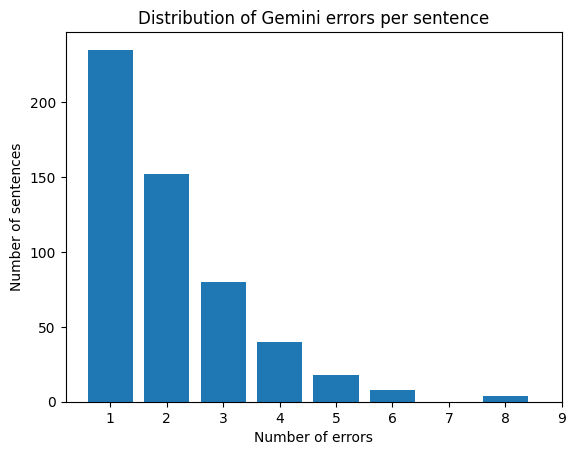

In [8]:
errors_per_sentence_gemini = [
    sum([1 for tag in row['tags'] if len(tag) > 2])
    for row in gemini_classifications
]

errors_per_sentence_gemini = [e for e in errors_per_sentence_gemini if e > 0]

# Plot histogram of errors per sentence
plt.hist(errors_per_sentence_gemini, bins=range(1, max(errors_per_sentence_gemini) + 1), align='left', rwidth=0.8)
plt.xticks(range(1, max(errors_per_sentence_gemini) + 1))
plt.xlabel('Number of errors')
plt.ylabel('Number of sentences')
plt.title('Distribution of Gemini errors per sentence')
plt.show()

We compare this histogram with the histogram of the logistic regression tagger from the `ud_pos_tagger_sklearn.ipynb` notebook (only the bins 1-3 because that's the slice we've taken in the first place)

We can see that Gemini might make less mistakes overall, but the number of sentences with 4+ mistakes is larger with the Gemini tagger compared to the LRT.

The conclusion is that Gemini is generally better but might make more mistakes on a single sentence.

## Error Explanation and Synthetic Data

In [9]:
import os
from prompts import explain_error_prompt
from schema import UDPosTag, TaggerErrorExplanation
from google import genai


gemini_model = 'gemini-2.0-flash-lite'
api_key = os.environ.get("GOOGLE_API_KEY")


def prompt_gemini_error(row):
    # assumes row has to tokenization errors
    sentence_tokens = [tag['predicted_token'] for tag in row['tags']]
    predicted_tags = [UDPosTag(tag['predicted_tag']) for tag in row['tags']]
    correct_tags = [UDPosTag(tag.get('correct_tag', tag['predicted_tag'])) for tag in row['tags']]

    prompt = explain_error_prompt(
        sentence_tokens=sentence_tokens,
        predicted_tags=predicted_tags,
        correct_tags=correct_tags
    )

    # Send prompt to the Gemini API
    client = genai.Client(api_key=api_key)
    response = client.models.generate_content(
        model=gemini_model,
        contents=prompt,
        config={
            'response_mime_type': 'application/json',
            'temperature': 0.0,
        },
    )

    if response.text is None:
        raise ValueError("No response from Gemini API. Please check your API key and network connection.")
    
    resp_list = json.loads(response.text)
    assert isinstance(resp_list, list), "LLM response should be a list"

    # check that the response is a list of TaggerErrorExplanation objects
    [TaggerErrorExplanation(**item) for item in resp_list]

    return resp_list

In [10]:
from tqdm import tqdm

# get rows without tokenization errors, sorted by the number of tagging errors
# do not account for first 10% of rows, as they are likely to be anomalies
rows_without_tok_errs = sorted([
    row
    for row in gemini_classifications
    if len([tag for tag in row['tags'] if 'correct_token' in tag or tag['predicted_tag'] is None]) == 0
], key=lambda row: len([tag for tag in row['tags'] if 'correct_tag' in tag]), reverse=True)[int(0.1*len(gemini_classifications)):]

K = 50

synthetic_data = []
for row in tqdm(rows_without_tok_errs[:K], desc="Explaining mistakes"):
    synthetic_data.append({
        'row': row,
        'explanation': prompt_gemini_error(row)
    })

# Save the synthetic data to a JSON file
with open('synthetic_data.json', 'w') as f:
    json.dump(synthetic_data, f, indent=2)
print(f"Saved {len(synthetic_data)} synthetic data points to 'synthetic_data.json'")

print(json.dumps(synthetic_data, indent=2))

Explaining mistakes: 100%|██████████| 50/50 [01:57<00:00,  2.35s/it]

Saved 50 synthetic data points to 'synthetic_data.json'
[
  {
    "row": {
      "sentence": "Zarqawi is a Jordanian, and his Monotheism and Holy War group in Afghanistan probably had a distinctive coloration as mainly Jordanian, Palestinian and Syrian.",
      "tags": [
        {
          "predicted_token": "Zarqawi",
          "predicted_tag": "PROPN"
        },
        {
          "predicted_token": "is",
          "predicted_tag": "AUX"
        },
        {
          "predicted_token": "a",
          "predicted_tag": "DET"
        },
        {
          "predicted_token": "Jordanian",
          "correct_tag": "PROPN",
          "predicted_tag": "ADJ"
        },
        {
          "predicted_token": ",",
          "predicted_tag": "PUNCT"
        },
        {
          "predicted_token": "and",
          "predicted_tag": "CCONJ"
        },
        {
          "predicted_token": "his",
          "predicted_tag": "PRON"
        },
        {
          "predicted_token": "Monotheism",

In [14]:
all_categories = set()
for row in synthetic_data:
    for explanation in row['explanation']:
        all_categories.add(explanation['category'])

print(f"Found {len(all_categories)} unique categories in the explanations")
print(json.dumps(list(all_categories), indent=2))

Found 52 unique categories in the explanations
[
  "Abbreviation/Short Form",
  "Adjective vs. Adverb Misclassification",
  "Morphological Ambiguity",
  "Incorrect POS Tagging",
  "Incorrect Proper Noun Identification",
  "Syntactic Function",
  "Proper Noun vs. Adjective",
  "Adverb vs. Noun",
  "Abbreviation/Acronym Misclassification",
  "Lexical Item",
  "Pronoun/Determiner Misclassification",
  "Morphological Error",
  "File Name/Unintelligible Material",
  "Proper Noun vs. Common Noun",
  "Adjective vs. Proper Noun",
  "Named Entity Recognition",
  "Adposition vs. Subordinating Conjunction",
  "Unusual Usage",
  "File Name/Unclear",
  "Pronoun vs. Determiner",
  "Proper Noun/Common Noun Misclassification",
  "Verb vs. Auxiliary Misidentification",
  "Incorrect Noun Classification",
  "Adjective vs. Proper Noun Misclassification",
  "Verb Identification",
  "Syntactic Error",
  "Verb/Adjective Misclassification",
  "Abbreviation/Lexical Category",
  "Token Type",
  "Phrasal Verb",
